# 电磁色散关系图（单粒子动力学）

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

## $\bf{k} \parallel \bf{B}_0$
- R波色散关系$n^2=R$

$$ \frac{k^2c^2}{\omega^2} = 1 - \frac{\omega_{pe}^2}{\omega^2} \frac{1}{1-\frac{|\omega_{ce}|}{\omega} } -\frac{\omega_{pi}^2}{\omega^2} \frac{1}{1+\frac{\omega_{ci}}{\omega} } $$

- L波色散关系$n^2=L$

$$ \frac{k^2c^2}{\omega^2} = 1 - \frac{\omega_{pe}^2}{\omega^2} \frac{1}{1+\frac{|\omega_{ce}|}{\omega} } -\frac{\omega_{pi}^2}{\omega^2} \frac{1}{1-\frac{\omega_{ci}}{\omega} } $$

- $R=0$截止频率$\omega_R$和$L=0$截止频率$\omega_L$

$$ \omega_R = \sqrt{ \frac{(\omega_{ce}-\omega_{ci})^2}{4} + \omega_{ce}\omega_{ci} + \omega_{pe}^2 + \omega_{pi}^2 } + \frac{\omega_{ce}-\omega_{ci}}{2} $$
$$ \omega_L = \sqrt{ \frac{(\omega_{ce}-\omega_{ci})^2}{4} + \omega_{ce}\omega_{ci} + \omega_{pe}^2 + \omega_{pi}^2 } - \frac{\omega_{ce}-\omega_{ci}}{2} $$

In [205]:
ne = 1
ni = 1
qe = 1
qi = 1
me = 1
mi = 6
B0 = 1.1

In [206]:
wpe = np.sqrt(ne*qe**2/me)
wpi = np.sqrt(ni*qi**2/mi)
wce = qe*B0/me
wci = qi*B0/mi

wR = np.sqrt((wce-wci)**2/4+wpe**2+wpi**2+wce*wci)+(wce-wci)/2
wL = np.sqrt((wce-wci)**2/4+wpe**2+wpi**2+wce*wci)-(wce-wci)/2
va = B0/np.sqrt(mi*ni)

paras_table = PrettyTable([r'$B_0=$'+str(B0),'n','m','q','wp','wc'])
paras_table.add_row(['e',ne,me,qe,round(wpe,4),round(wce,4)])
paras_table.add_row(['i',ni,mi,qi,round(wpi,4),round(wci,4)])
print(paras_table)
print('wR=',wR)
print('wL=',wL)
print('va=',va)

+-----------+---+---+---+--------+--------+
| $B_0=$1.1 | n | m | q |   wp   |   wc   |
+-----------+---+---+---+--------+--------+
|     e     | 1 | 1 | 1 |  1.0   |  1.1   |
|     i     | 1 | 6 | 1 | 0.4082 | 0.1833 |
+-----------+---+---+---+--------+--------+
wR= 1.7146783407965613
wL= 0.7980116741298945
va= 0.4490731195102494


In [207]:
def R_dispersion(w,kc):
    re = wpe**2/w/(w-wce)
    ri = wpi**2/w/(w+wci)
    n2 = (kc/w)**2
    return 1-re-ri-n2
def L_dispersion(w,kc):
    re = wpe**2/w/(w+wce)
    ri = wpi**2/w/(w-wci)
    n2 = (kc/w)**2
    return 1-re-ri-n2

In [208]:
kc_list = np.linspace(0.01,3.0,num=600)

w_r_lo_guess = 0.01*va
w_l_lo_guess = 0.01*va
w_r_up_guess = wR
w_l_up_guess = wL

w_r_lo_list = np.array([])
w_r_up_list = np.array([])
w_l_lo_list = np.array([])
w_l_up_list = np.array([])

for kc_each in tqdm(kc_list,position=0,leave=True):
    sr_lo = op.root(lambda w:R_dispersion(w,kc_each),w_r_lo_guess)
    if sr_lo.success==True:
        w_r_lo_guess = round(sr_lo.x[0],10)
        w_r_lo_list = np.append(w_r_lo_list,sr_lo.x[0])
    else:
        w_r_lo_list = np.append(w_r_lo_list,np.nan)
        
    sl_lo = op.root(lambda w:L_dispersion(w,kc_each),w_l_lo_guess)
    if sl_lo.success==True:
        w_l_lo_guess = round(sl_lo.x[0],6)
        w_l_lo_list = np.append(w_l_lo_list,sl_lo.x[0])
    else:
        w_l_lo_list = np.append(w_l_lo_list,np.nan)
        
    sr_up = op.root(lambda w:R_dispersion(w,kc_each),w_r_up_guess)
    if sr_up.success==True:
        w_r_up_guess = round(sr_up.x[0],10)
        w_r_up_list = np.append(w_r_up_list,sr_up.x[0])
    else:
        w_r_up_list = np.append(w_r_up_list,np.nan)
        
    sl_up = op.root(lambda w:L_dispersion(w,kc_each),w_l_up_guess)
    if sl_up.success==True:
        w_l_up_guess = round(sl_up.x[0],6)
        w_l_up_list = np.append(w_l_up_list,sl_up.x[0])
    else:
        w_l_up_list = np.append(w_l_up_list,np.nan)

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 2040.60it/s]


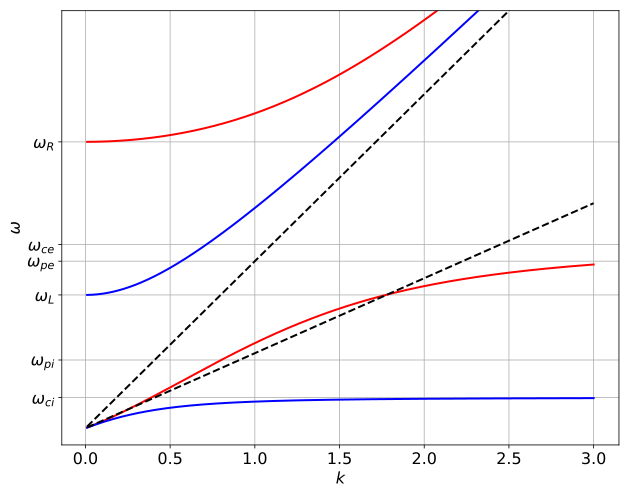

In [211]:
fig = plt.figure(figsize=(10,8))
# x_ticks = np.linspace(0.0,3.0,num=9)

ax1 = plt.subplot(111)
ax1.set_xlabel('$k$')
# plt.xticks(x_ticks)
plt.yticks([wpi,wci,wce,wpe,wR,wL],[r'$\omega_{pi}$',r'$\omega_{ci}$',r'$\omega_{ce}$',r'$\omega_{pe}$',r'$\omega_R$',r'$\omega_L$'])

ax1.set_ylabel(r'$\omega$')
ax1.grid()

ax1.plot(kc_list,w_r_lo_list,color='red')
ax1.plot(kc_list,w_r_up_list,color='red')
ax1.plot(kc_list,w_l_lo_list,color='blue')
ax1.plot(kc_list,w_l_up_list,color='blue')
ax1.plot(kc_list,va*kc_list,'--',color='black')
ax1.plot(kc_list,kc_list,'--',color='black')

plt.ylim(-0.1,2.5)
plt.show()

## $\bf{k} \perp \bf{B}_0$
- X波色散关系$n^2=R$

$$ \frac{k^2c^2}{\omega^2} = \frac{ (\omega^2-\omega^2_R)(\omega^2-\omega^2_L) }{ (\omega^2-\omega^2_{UH})(\omega^2-\omega^2_{LH}) } $$

- 高低混杂共振频率$S=0$

$$ \omega^2_{LH} = \frac{\omega^2_{ce}+\omega^2_{ci}+\omega^2_{pe}+\omega^2_{pi}}{2} 
                    -\sqrt{
                        \frac{(\omega^2_{ce}+\omega^2_{ci}+\omega^2_{pe}+\omega^2_{pi})^2}{4}
                        -\omega^2_{ce}\omega^2_{ci}-\omega^2_{ce}\omega^2_{pi}-\omega^2_{ci}\omega^2_{pe}
                       } $$
$$ \omega^2_{UH} = \frac{\omega^2_{ce}+\omega^2_{ci}+\omega^2_{pe}+\omega^2_{pi}}{2} 
                    +\sqrt{
                        \frac{(\omega^2_{ce}+\omega^2_{ci}+\omega^2_{pe}+\omega^2_{pi})^2}{4}
                        -\omega^2_{ce}\omega^2_{ci}-\omega^2_{ce}\omega^2_{pi}-\omega^2_{ci}\omega^2_{pe}
                       } $$

In [229]:
def X_dispersion(w,kc):
    return (w**2-wR**2)*(w**2-wL**2)/(w**2-wUH**2)/(w**2-wLH**2) - (kc/w)**2

In [230]:
A = wce**2+wci**2+wpe**2+wpi**2
B = wce**2*wci**2+wce**2*wpi**2+wpe**2*wci**2
wLH = np.sqrt(A/2 - np.sqrt(A**2/4-B))
wUH = np.sqrt(A/2 + np.sqrt(A**2/4-B))
print('wLH=',wLH)
print('wUH=',wUH)

wLH= 0.3471503544388357
wUH= 1.5131967516455909


In [231]:
w_x_lo_guess = 0.01*va
w_x_mi_guess = wL
w_x_up_guess = wR

w_x_lo_list = np.array([])
w_x_mi_list = np.array([])
w_x_up_list = np.array([])

for kc_each in tqdm(kc_list,position=0,leave=True):
    s_lo = op.root(lambda w:X_dispersion(w,kc_each),w_x_lo_guess)
    if s_lo.success==True:
        w_x_lo_guess = round(s_lo.x[0],10)
        w_x_lo_list = np.append(w_x_lo_list,s_lo.x[0])
    else:
        w_x_lo_list = np.append(w_x_lo_list,np.nan)
        
    s_mi = op.root(lambda w:X_dispersion(w,kc_each),w_x_mi_guess)
    if s_mi.success==True:
        w_x_mi_guess = round(s_mi.x[0],6)
        w_x_mi_list = np.append(w_x_mi_list,s_mi.x[0])
    else:
        w_x_mi_list = np.append(w_x_mi_list,np.nan)
        
    s_up = op.root(lambda w:X_dispersion(w,kc_each),w_x_up_guess)
    if s_up.success==True:
        w_x_up_guess = round(s_up.x[0],6)
        w_x_up_list = np.append(w_x_up_list,s_up.x[0])
    else:
        w_x_up_list = np.append(w_x_up_list,np.nan)

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 2165.77it/s]


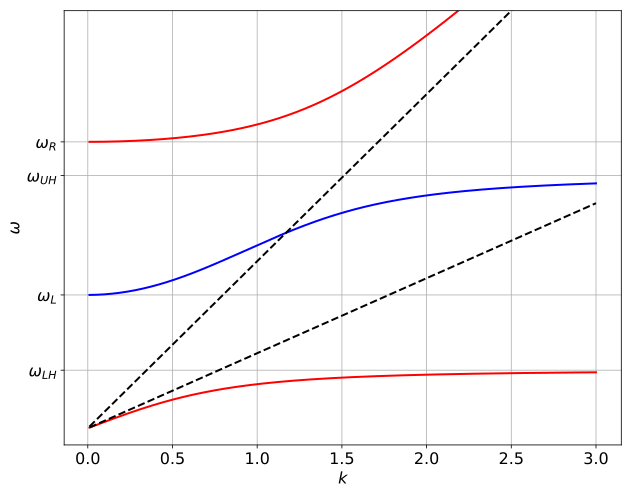

In [234]:
fig = plt.figure(figsize=(10,8))

ax1 = plt.subplot(111)
ax1.set_xlabel('$k$')
plt.yticks([wLH,wUH,wR,wL],[r'$\omega_{LH}$',r'$\omega_{UH}$',r'$\omega_R$',r'$\omega_L$'])

ax1.set_ylabel(r'$\omega$')
ax1.grid()

ax1.plot(kc_list,w_x_lo_list,color='red')
ax1.plot(kc_list,w_x_up_list,color='red')
ax1.plot(kc_list,w_x_mi_list,color='blue')
ax1.plot(kc_list,va*kc_list,'--',color='black')
ax1.plot(kc_list,kc_list,'--',color='black')

plt.ylim(-0.1,2.5)
plt.show()